Presented by: Reza Saadatyar 2022-2023<br/>
E-mail: Reza.Saadatyar92@gmail.com<br/>
[Link](https://github.com/RezaSaadatyar/Deep-Learning-in-python)

**Recurrent Neurons and Layers**

![Alt text](1.jpg)
![Alt text](2.jpg)

================================== Importing the required Libraries ===========================

In [2]:
import os
import sys
import math 
import numpy as np
import pandas as pd
import yfinance as yf          # pip install yfinance
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

========================================= Functions ==================================

In [4]:
# =============================================== Preparing data =====================================================
def Prepare_data(data):  
     # -------------------------------------------- Step 1.1: Check type data ----------------------------------------     
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    return data

# ============================================= Sequences data =======================================================
def sequences_data(data, x_steps=6, y_steps=3, train_size=0.7, nfeatures=1):
    # !============================================= Step 1: Split data ==============================================
    # -------------------------------------------- Step 1.1: Check type data -----------------------------------------    
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # ---------------------------------------- Step 1.2: Check dimensional data --------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # ----------------------------------------------- Step 1.3: split ------------------------------------------------   
    n = math.floor(data.shape[0] * train_size)
    data_train = data.iloc[0:n,:].values.reshape(-1,1)
    data_test = data.iloc[data_train.shape[0]-x_steps:,:].values.reshape(-1,1)
    # !============================================== Step 2: Normalize ==============================================
    mod = MinMaxScaler(feature_range=(0, 1))
    # data_train = mod.fit_transform(data_train)
    # data_test = mod.transform(data_test.reshape(-1,1))
    # !============================================== Step 3: Sequences ==============================================
    # --------------------------------------------- Step 3.1: Sequences x_train --------------------------------------
    x_train = []
    y_train = []
    for i in range(x_steps, len(data_train)-y_steps+1):
        x_train.append(data_train[i-x_steps:i, 0])
        y_train.append(data_train[i:i+y_steps, 0])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], nfeatures))
    # -------------------------------------------- Step 3.2: Sequences x_test ----------------------------------------
    x_test = []
    y_test = []
    for i in range(x_steps, len(data.iloc[n:,:])+x_steps-y_steps+1):
        x_test.append(data_test[i-x_steps:i, 0])
        y_test.append(data_test[i:i+y_steps, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, mod

*Step 1.1: Load Data*

In [5]:
data = sm.datasets.sunspots.load_pandas()  
data = data.data["SUNACTIVITY"]

In [6]:
data = Prepare_data(data)
print(f"{data = }")

data =      SUNACTIVITY
0            5.0
1           11.0
2           16.0
3           23.0
4           36.0
..           ...
304         40.4
305         29.8
306         15.2
307          7.5
308          2.9

[309 rows x 1 columns]


*Step 1.2: Plot data*

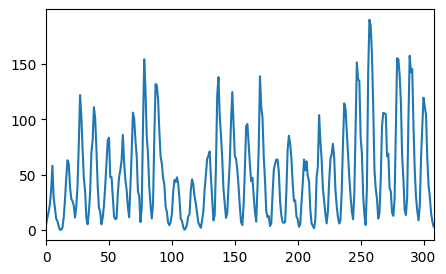

In [7]:
_, axs = plt.subplots(nrows=1,sharey='row', figsize=(5,3))
axs.plot(data)
axs.set_xlabel('', fontsize=10)
axs.set_title(f"", fontsize=10)
axs.set_ylabel('', fontsize=10)
axs.autoscale(enable=True, axis="x",tight=True)

*Step 2: Sequences*

In [22]:
x_steps = 6
y_steps = 2
x_train, y_train, x_test, y_test, mod = sequences_data(data, x_steps, y_steps, train_size=0.6, nfeatures=1)

*Step 3: Creating a Sequential model:*<br/>
[Sequential model](https://keras.io/guides/sequential_model/)<br/>
[Dense layer](https://keras.io/api/layers/core_layers/dense/)<br/>
[Activation functions](https://keras.io/api/layers/activations/)<br/>
[Flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/)<br/>

*Step 3.1: Simple Recurrent Neural Networks ([RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN))-Model*<br/>
*inputs $\Rightarrow$ A 3D tensor, with shape [batch, timesteps, feature].*

In [23]:
simple_rnn_mod = Sequential([SimpleRNN(50, return_sequences=True),
                            SimpleRNN(50),
                            Dense(y_steps)])
simple_rnn_mod.layers                     # Print the model parameters

*Step 3.2: [Model compile](https://keras.io/api/models/model_training_apis/)*<br/>
[Metrics](https://keras.io/api/metrics/regression_metrics/)<br/>

In [24]:
simple_rnn_mod.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])  # Regression:mean_squared_error

*Step 3.3: Fit Model*<br/>
[Fit method](https://keras.io/api/models/model_training_apis/)

In [25]:
simple_rnn_mod.fit(x_train, y_train, epochs=100, validation_split=0.15)

Epoch 1/100
5/5 [==============================] - 8s 360ms/step - loss: 3145.3496 - mean_absolute_error: 43.4745 - val_loss: 3749.4956 - val_mean_absolute_error: 50.4097
Epoch 2/100
5/5 [==============================] - 0s 31ms/step - loss: 3041.3181 - mean_absolute_error: 42.3044 - val_loss: 3642.9441 - val_mean_absolute_error: 49.3561
Epoch 3/100
5/5 [==============================] - 0s 32ms/step - loss: 2955.1975 - mean_absolute_error: 41.3743 - val_loss: 3552.7905 - val_mean_absolute_error: 48.4414
Epoch 4/100
5/5 [==============================] - 0s 31ms/step - loss: 2884.5615 - mean_absolute_error: 40.5821 - val_loss: 3478.4512 - val_mean_absolute_error: 47.7258
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 2825.8684 - mean_absolute_error: 39.9427 - val_loss: 3417.4143 - val_mean_absolute_error: 47.1299
Epoch 6/100
5/5 [==============================] - 0s 21ms/step - loss: 2780.5928 - mean_absolute_error: 39.4357 - val_loss: 3369.8528 - val_mean_abs

In [64]:
y_train.shape

(208, 3)

In [38]:
x_test

array([[ 18.6,   5.7,   3.6,   1.4,   9.6,  47.4],
       [  5.7,   3.6,   1.4,   9.6,  47.4,  57.1],
       [  3.6,   1.4,   9.6,  47.4,  57.1, 103.9],
       [  1.4,   9.6,  47.4,  57.1, 103.9,  80.6],
       [  9.6,  47.4,  57.1, 103.9,  80.6,  63.6],
       [ 47.4,  57.1, 103.9,  80.6,  63.6,  37.6],
       [ 57.1, 103.9,  80.6,  63.6,  37.6,  26.1],
       [103.9,  80.6,  63.6,  37.6,  26.1,  14.2],
       [ 80.6,  63.6,  37.6,  26.1,  14.2,   5.8],
       [ 63.6,  37.6,  26.1,  14.2,   5.8,  16.7],
       [ 37.6,  26.1,  14.2,   5.8,  16.7,  44.3],
       [ 26.1,  14.2,   5.8,  16.7,  44.3,  63.9],
       [ 14.2,   5.8,  16.7,  44.3,  63.9,  69. ],
       [  5.8,  16.7,  44.3,  63.9,  69. ,  77.8],
       [ 16.7,  44.3,  63.9,  69. ,  77.8,  64.9],
       [ 44.3,  63.9,  69. ,  77.8,  64.9,  35.7],
       [ 63.9,  69. ,  77.8,  64.9,  35.7,  21.2],
       [ 69. ,  77.8,  64.9,  35.7,  21.2,  11.1],
       [ 77.8,  64.9,  35.7,  21.2,  11.1,   5.7],
       [ 64.9,  35.7,  21.2,  1

In [39]:
y_test

array([[ 57.1, 103.9,  80.6],
       [103.9,  80.6,  63.6],
       [ 80.6,  63.6,  37.6],
       [ 63.6,  37.6,  26.1],
       [ 37.6,  26.1,  14.2],
       [ 26.1,  14.2,   5.8],
       [ 14.2,   5.8,  16.7],
       [  5.8,  16.7,  44.3],
       [ 16.7,  44.3,  63.9],
       [ 44.3,  63.9,  69. ],
       [ 63.9,  69. ,  77.8],
       [ 69. ,  77.8,  64.9],
       [ 77.8,  64.9,  35.7],
       [ 64.9,  35.7,  21.2],
       [ 35.7,  21.2,  11.1],
       [ 21.2,  11.1,   5.7],
       [ 11.1,   5.7,   8.7],
       [  5.7,   8.7,  36.1],
       [  8.7,  36.1,  79.7],
       [ 36.1,  79.7, 114.4],
       [ 79.7, 114.4, 109.6],
       [114.4, 109.6,  88.8],
       [109.6,  88.8,  67.8],
       [ 88.8,  67.8,  47.5],
       [ 67.8,  47.5,  30.6],
       [ 47.5,  30.6,  16.3],
       [ 30.6,  16.3,   9.6],
       [ 16.3,   9.6,  33.2],
       [  9.6,  33.2,  92.6],
       [ 33.2,  92.6, 151.6],
       [ 92.6, 151.6, 136.3],
       [151.6, 136.3, 134.7],
       [136.3, 134.7,  83.9],
       [13